In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from pylr2 import regress2
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
from pyspark.sql import functions as F

import matplotlib.pyplot as plt

In [3]:
from src.data import spark_postgis
from src import constants

In [4]:
spark = spark_postgis.get_spark()

23/09/23 09:04:50 WARN Utils: Your hostname, sherwood resolves to a loopback address: 127.0.1.1; using 128.232.93.0 instead (on interface enp193s0f0np0)
23/09/23 09:04:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/ah2174/gedi-disturbance/venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ah2174/.ivy2/cache
The jars for the packages stored in: /home/ah2174/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
net.postgis#postgis-jdbc added as a dependency
net.postgis#postgis-geometry added as a dependency
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-958ee0d0-ddaf-4b7c-8fc9-fa077ec75cf9;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.3.1-incubating in central
	found org.locationtech.jts#jts-core;1.18.2 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.3.1-incubating in central
	found org.apache.sedona#sedona-common;1.3.1-incubating in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.3.1-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.data

23/09/23 09:04:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/23 09:04:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/23 09:04:52 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [5]:
sdf_all = spark.read.parquet((constants.RESULTS_PATH / "gedi_neighbors_nau_l24a").as_posix())
sdf_all.createOrReplaceTempView("shots_table")
sdf_all = spark.sql("SELECT *, ST_GeomFromWKB(t1_geometry) AS t1_geom, ST_GeomFromWKB(t2_geometry) AS t2_geom FROM shots_table")
sdf_all = sdf_all.drop("t1_geometry", "t2_geometry")
print(sdf_all.count())
sdf_all.show(3)

4189899


+-----------------+------------------+--------------------+------------+--------------+------------------+-----------------+-----------------+--------------------+------------+--------------+------------------+-------------+--------+------------+--------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+---------------+-----------------+-----------------+-----------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-------------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---

In [6]:
sdf_intact_s1 = spark.read.parquet((constants.RESULTS_PATH / "intact_control_s1").as_posix())
sdf_intact_s2 = spark.read.parquet((constants.RESULTS_PATH / "intact_control_s2").as_posix())
sdf_intact = sdf_intact_s1.select(["t1_shot_number", "t2_shot_number"]).join(sdf_intact_s2, on=["t1_shot_number", "t2_shot_number"], how="inner")
print(sdf_intact.count())
sdf_intact.show(3)

2513217


+-----------------+------------------+------------------+--------------------+------------+--------------+------------------+------------------+--------------------+------------+--------------+------------------+-------------+--------+------------+--------+----------------+-----------------+-----------------+------------------+-----------------+-----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------------+----------------+----------------

In [7]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_radd_singlelayer").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
radd_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
radd_df.loc[radd_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
radd_df.loc[radd_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(radd_df))
print(len(radd_df[radd_df["sample_grp"] == "treatment"]))
print(len(radd_df[radd_df["sample_grp"] == "control"]))

41956
7244
34712


In [8]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, col
degrade_sdf = spark.read.parquet((constants.RESULTS_PATH / "gedi_degradation_afc_2022").as_posix())
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

degrade_sdf = degrade_sdf.withColumn("time_diff", (degrade_sdf["t2_absolute_time"] - degrade_sdf["t1_absolute_time"]))
degrade_sdf = degrade_sdf.withColumn("time_diff", get_days(col("time_diff")))
afc_df = gpd.GeoDataFrame(degrade_sdf.toPandas(), geometry="t2_geom").copy()
afc_df.loc[afc_df.control_disturbance > 0, "sample_grp"] = "control"
# Note: points may have a control disturbance as well as a measured disturbance.
# in that case, we include them in the treatment group; we don't care that they
# were also disturbed at another, unmeasured time.
afc_df.loc[afc_df.measured_disturbance > 0, "sample_grp"] = "treatment"
print(len(afc_df))
print(len(afc_df[afc_df["sample_grp"] == "treatment"]))
print(len(afc_df[afc_df["sample_grp"] == "control"]))

58753
3983
54770


## Temporal distribution of shot pairs

In [9]:
@udf(returnType=IntegerType())
def get_days(time_delta):
  return time_delta.days

def add_time_diff(_sdf):
  _sdf = _sdf.withColumn("time_diff", (_sdf["t2_absolute_time"] - _sdf["t1_absolute_time"]))
  _sdf = _sdf.withColumn("time_diff", get_days(col("time_diff")))
  return _sdf

In [10]:
sdf_all = add_time_diff(sdf_all)
sdf_intact = add_time_diff(sdf_intact)
radd_df["time_diff"] = (radd_df.t2_absolute_time - radd_df.t1_absolute_time).dt.days
afc_df["time_diff"] = (afc_df.t2_absolute_time - afc_df.t1_absolute_time).dt.days

In [11]:
# Remove shot pairs with zero days between shots
sdf_all = sdf_all.filter(sdf_all.time_diff != 0)
sdf_intact = sdf_intact.filter(sdf_intact.time_diff != 0)
print(sdf_all.count())

time_diffs = np.array(sdf_intact.select("time_diff").rdd.flatMap(lambda x: x).collect())

4185566


In [12]:
def temporal_adjust(df_orig):
    bins = np.arange(0, 1200, 60)
    df_orig["time_diff_bin"] = pd.cut(df_orig["time_diff"], bins=bins)
    treatment_dist = df_orig[df_orig.sample_grp == "treatment"].groupby("time_diff_bin").size().reset_index(name="count")
    print(treatment_dist)

    new_control = []
    new_treatment = []
    for i in range(0, len(treatment_dist)):
        bin, count = treatment_dist.iloc[i]["time_diff_bin"], treatment_dist.iloc[i]["count"]
        c = df_orig[(df_orig.sample_grp == "control") & (df_orig.time_diff_bin == bin)]
        t = df_orig[(df_orig.sample_grp == "treatment") & (df_orig.time_diff_bin == bin)]
        if len(t) != count:
            print(f"I am confused: {bin}")
        if len(c) < count:
            new_treatment.append(t.sample(len(c), replace=False))
            new_control.append(c)
        else:
            new_control.append(c.sample(count, replace=False))
            new_treatment.append(t)

    new_control = pd.concat(new_control)
    new_treatment = pd.concat(new_treatment)
    return pd.concat([new_control, new_treatment])



In [ ]:
radd_df_adjust = temporal_adjust(radd_df)
_tmp = radd_df_adjust
print((_tmp[_tmp.sample_grp == "control"].t2_agbd_a0 - _tmp[_tmp.sample_grp == "control"].t1_agbd_a0).mean())
afc_df_adjust = temporal_adjust(afc_df)
_tmp = afc_df_adjust
print((_tmp[_tmp.sample_grp == "control"].t2_agbd_a0 - _tmp[_tmp.sample_grp == "control"].t1_agbd_a0).mean())

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
time_diffs = time_diffs[time_diffs != 0]
plt.hist(time_diffs, bins = 100)
quantiles = [0.10, 0.25, 0.5, 0.75, 0.98]
quantile_vals = np.quantile(time_diffs, q=quantiles)
for i,q in enumerate(quantiles):
    v = quantile_vals[i]
    plt.plot((v, v), (0, 600000), color="tab:red", linestyle="dotted")
    plt.text(v+2, 600000, f"{q * 100:.0f}%")
    # plt.text(v+2, 20000, f"{v:.0f}")
print(quantile_vals)
plt.xlabel("Time between shots (days)")
plt.ylabel("N shot pairs")

In [ ]:
from matplotlib.lines import Line2D
import seaborn as sns

datas = [radd_df, radd_df_adjust]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,12))
bin_count = 20
for i, data in enumerate(datas):
    axi = ax[0, i]
    sns.histplot(data[data.sample_grp == "treatment"].t1_absolute_time, ax=axi, color="blue", bins=bin_count)
    sns.histplot(data[data.sample_grp == "treatment"].t2_absolute_time, ax=axi, color="red", bins=bin_count)
    axi.set_xlabel("Date")
    axi.set_title("Treatment")
    legend_elements = [
            Line2D([0], [0], marker='o', color='blue', label="Shot 1",
                markerfacecolor='blue', markersize=7, linestyle='None'),
            Line2D([0], [0], marker='o', color='red', label="Shot 2",
                markerfacecolor='red', markersize=7, linestyle='None'),
        ]
    axi.legend(handles=legend_elements)
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))

    axi = ax[1, i]
    sns.histplot(data[data.sample_grp == "control"].t1_absolute_time, ax=axi, color="blue", bins=bin_count)
    sns.histplot(data[data.sample_grp == "control"].t2_absolute_time, ax=axi, color="red", bins=bin_count)
    axi.set_xlabel("Date")
    axi.set_title("Control")
    legend_elements = [
            Line2D([0], [0], marker='o', color='blue', label="Shot 1",
                markerfacecolor='blue', markersize=7, linestyle='None'),
            Line2D([0], [0], marker='o', color='red', label="Shot 2",
                markerfacecolor='red', markersize=7, linestyle='None'),
        ]
    axi.legend(handles=legend_elements)
    axi.xaxis.set_major_locator(plt.MaxNLocator(3))

    axi = ax[2, i]
    sns.histplot(
        (
        data[data.sample_grp == "control"].time_diff), ax=axi, color="green", bins=20)

    sns.histplot(data[data.sample_grp == "treatment"].time_diff, ax=axi, color="orange", bins=20)
    axi.set_xlabel("Time between shots (days)")
    legend_elements = [
            Line2D([0], [0], marker='o', color='green', label="Control",
                markerfacecolor='green', markersize=7, linestyle='None'),
            Line2D([0], [0], marker='o', color='orange', label="Treatment",
                markerfacecolor='orange', markersize=7, linestyle='None'),
        ]
    axi.legend(handles=legend_elements)


plt.tight_layout()
plt.show()

## Spatial distribution of shot pairs

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt


sdf_filt = gpd.GeoDataFrame(
    sdf_intact
        .sample(withReplacement=False, fraction=0.2)
    .select("t1_geom", "time_diff")
    .toPandas(), geometry="t1_geom", crs=constants.WGS84)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-85, -40, -20, 10], crs=ccrs.PlateCarree())

# Background: Stamen terrain with added Cartopy features
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 8)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Add the colorbar axes anywhere in the figure. Its position will be
# re-calculated after the main plot is drawn
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
cbar_orientation = "horizontal"
cbar_width = 0.03

# Plot our data
sdf_filt.plot(column='time_diff', zorder=10, markersize=1, ax=ax, cmap='OrRd_r', legend=True, legend_kwds={"orientation": cbar_orientation, "label": "Time between shots (days)"}, cax=cbar_ax)


## Find the location of the main plot axes now that the plot has been drawn, and stick our colorbar there.
posn = ax.get_position()
if cbar_orientation == "vertical":
    cbar_ax.set_position([posn.x0+posn.width+0.05, posn.y0, cbar_width, posn.height])
    cbar_ax.tick_params(axis="y", which="major", labelsize=15)
    cbar_ax.yaxis.label.set_size(15)
if cbar_orientation == "horizontal":
    cbar_ax.set_position([posn.x0, posn.y0-0.07, posn.width, cbar_width])
    cbar_ax.tick_params(axis="x", which="major", labelsize=15)
    cbar_ax.xaxis.label.set_size(15)

# Longitude and latitude degrees on the axes
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# region
region = gpd.read_file("/home/ah2174/shapefiles/Amazon_rainforest_shapefile.zip")
region.plot(ax=ax, color="none", edgecolor="greenyellow", linewidth=3, zorder=10)

plt.show()

## Correlation and bias versus time, distance

In [13]:
sdf_all = sdf_all.withColumn("proj", spark_postgis.get_utm_projection(col("t1_geom")))
sdf_all.createOrReplaceTempView("shots_table")

In [14]:
sdf_30m = spark.sql("""
    SELECT * 
    FROM shots_table 
    WHERE ST_DISTANCE(
        ST_Transform(t1_geom, "epsg:4326", proj),
        ST_Transform(t2_geom, "epsg:4326", proj)) < 30""")

# Write out and then reread back in ...
# For some reason spark seems to recompute this every time we try to use it o/w.
sdf_30m.write.mode("overwrite").format("geoparquet").save(
    "/maps/forecol/results/gedi_neighbors_nau_l24a_30m"
)


In [15]:

sdf_30m = spark.read.parquet(
    "/maps/forecol/results/gedi_neighbors_nau_l24a_30m"
)

In [16]:
sdf_30m = (sdf_30m
    .withColumn("agbd_diff", sdf_30m.t2_agbd_a0 - sdf_30m.t1_agbd_a0)
    .withColumn("rh98_diff", sdf_30m.t2_rh_98_a0 - sdf_30m.t1_rh_98_a0)
)
sdf_30m.select(F.mean("agbd_diff")).show()
sdf_30m.select(F.mean("rh98_diff")).show()
print(sdf_30m.corr("t1_agbd_a0", "t2_agbd_a0"))
print(sdf_30m.corr("t1_rh_98_a0", "t2_rh_98_a0"))


+------------------+
|    avg(agbd_diff)|
+------------------+
|-4.111694633944897|
+------------------+

+--------------------+
|      avg(rh98_diff)|
+--------------------+
|-0.15711695610279638|
+--------------------+



0.6224176366062054
0.8278043243351961


In [17]:
from typing import List
from pyspark.sql.functions import mean

def get_stats(_sdf, lags: List[int]):
    lags.sort(reverse=True)
    var_agbd = []
    var_rh98 = []
    bias_agbd = []
    bias_rh98 = []
    counts = []
    for i in range(len(lags) - 1):
        _tmp = _sdf.filter(_sdf.time_diff >= lags[i+1]).filter(_sdf.time_diff < lags[i])
        n = _tmp.count()
        counts.append(n)
        print(f"{lags[i+1]}-{lags[i]}: {n}")
        if n == 0:
            continue
        var_agbd.append(_tmp.select(F.stddev(col("agbd_diff"))).collect()[0][0])
        var_rh98.append(_tmp.select(F.stddev(col("rh98_diff"))).collect()[0][0])
        bias_agbd.append(_tmp.select(F.mean(col("agbd_diff"))).collect()[0][0])
        bias_rh98.append(_tmp.select(F.mean(col("rh98_diff"))).collect()[0][0])
    return var_agbd, var_rh98, bias_agbd, bias_rh98, counts

In [18]:
time_lags = [1100, 1000, 900, 800, 700, 600, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50, 0]
sdf_all = sdf_all.withColumn("agbd_diff", col("t2_agbd_a0") - col("t1_agbd_a0"))
sdf_all = sdf_all.withColumn("rh98_diff", col("t2_rh_98_a0") - col("t1_rh_98_a0"))
sdf_intact = sdf_intact.withColumn("agbd_diff", col("t2_agbd_a0") - col("t1_agbd_a0"))
sdf_intact = sdf_intact.withColumn("rh98_diff", col("t2_rh_98_a0") - col("t1_rh_98_a0"))
# sdf_30m = sdf_30m.withColumn("agbd_diff", col("t2_agbd_a0") - col("t1_agbd_a0"))
# sdf_30m = sdf_30m.withColumn("rh98_diff", col("t2_rh_98_a0") - col("t1_rh_98_a0"))
# var_agbd, var_rh98, bias_agbd, bias_rh98, counts = get_stats(sdf_all, time_lags)
# var_agbd_30m, var_rh98_30m, bias_agbd_30m, bias_rh98_30m, counts_30m = get_stats(sdf_30m, time_lags)
# print(bias_agbd)
# print(counts)


In [ ]:
from matplotlib.lines import Line2D
n_lags = len(time_lags) - 1
lags_text = [f"[{time_lags[n_lags - i]},{time_lags[n_lags - (i+1)]})" for i in range(n_lags)]
x_lags = time_lags[1:]
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axi = ax[0,0]
axi.scatter(x=x_lags, y=var_agbd, color="darkorange")
axi.scatter(x=x_lags, y=var_agbd_30m, color="bisque")
axi.set_xlabel("Time between shots (days)")
axi.set_ylabel("Standard deviation")
axi.set_title("AGBD: Time lag vs std deviation")
axi.set_xticks(x_lags, lags_text, rotation=45)
legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='< 30 m apart',
            markerfacecolor='bisque', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='< 40 m apart', 
            markerfacecolor='darkorange', markersize=5),]
axi.legend(handles=legend_elements)


axi = ax[0,1]
axi.scatter(x=x_lags, y=var_rh98, color="blue")
axi.scatter(x=x_lags, y=var_rh98_30m, color="lightsteelblue")
axi.set_xlabel("Time between shots (days)")
axi.set_title("RH 98: Time lag vs std deviation")
legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='< 30 m apart',
            markerfacecolor='lightsteelblue', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='< 40 m apart', 
            markerfacecolor='blue', markersize=5),]
axi.legend(handles=legend_elements)

axi = ax[1,0]
axi.scatter(x=x_lags, y=bias_agbd, color="darkorange")
axi.scatter(x=x_lags, y=bias_agbd_30m, color="bisque")
axi.set_xlabel("Time between shots (days)")
axi.set_ylabel("Bias (mean difference)")
axi.set_title("AGBD: Time lag vs Bias")
legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='< 30 m apart',
            markerfacecolor='bisque', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='< 40 m apart', 
            markerfacecolor='darkorange', markersize=5),]
axi.legend(handles=legend_elements)


axi = ax[1,1]
axi.scatter(x=x_lags, y=bias_rh98, color="blue")
axi.scatter(x=x_lags, y=bias_rh98_30m, color="lightsteelblue")
axi.set_xlabel("Time between shots (days)")
axi.set_title("RH 98: Time lag vs Bias")
legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='< 30 m apart',
            markerfacecolor='lightsteelblue', markersize=5),
        Line2D([0], [0], marker='o', color='w', label='< 40 m apart', 
            markerfacecolor='blue', markersize=5),]
axi.legend(handles=legend_elements)

In [26]:
def get_stats_pandas(df, lags):
    lags.sort(reverse=True)
    var_agbd = []
    var_rh98 = []
    bias_agbd = []
    bias_rh98 = []
    counts = []
    print(lags)
    for i in range(len(lags) - 1):
        _tmp = df[(df.time_diff >= lags[i+1]) & (df.time_diff < lags[i])]
        n = len(_tmp)
        counts.append(n)
        print(f"{lags[i+1]}-{lags[i]}: {n}")
        if n < 30:
            var_agbd.append(None)
            var_rh98.append(None)
            bias_agbd.append(None)
            bias_rh98.append(None)
            continue
        var_agbd.append(_tmp["agbd_diff"].std())
        var_rh98.append(_tmp["rh98_diff"].std())
        bias_agbd.append(_tmp["agbd_diff"].mean())
        bias_rh98.append(_tmp["rh98_diff"].mean())
    return var_agbd, var_rh98, bias_agbd, bias_rh98, counts


In [21]:
time_lags = [1200, 1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 0]
afc_df["agbd_diff"] = afc_df.t2_agbd_a0 - afc_df.t1_agbd_a0
afc_df["rh98_diff"] = afc_df.t2_rh_98_a0 - afc_df.t1_rh_98_a0
radd_df["agbd_diff"] = radd_df.t2_agbd_a0 - radd_df.t1_agbd_a0
radd_df["rh98_diff"] = radd_df.t2_rh_98_a0 - afc_df.t1_rh_98_a0
afc_stats = get_stats_pandas(afc_df[afc_df.sample_grp == "control"], time_lags)
radd_stats = get_stats_pandas(radd_df[radd_df.sample_grp == "control"], time_lags)
all_stats = get_stats(sdf_all, time_lags)
intact_stats = get_stats(sdf_intact, time_lags)

[1200, 1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 0]
1000-1200: 0
900-1000: 0
800-900: 196
700-800: 700
600-700: 1606
500-600: 1496
400-500: 4420
300-400: 10262
200-300: 9247
100-200: 9509
50-100: 3558
0-50: 13776
[1200, 1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 0]
1000-1200: 8
900-1000: 574
800-900: 80
700-800: 474
600-700: 1030
500-600: 835
400-500: 3599
300-400: 6401
200-300: 6583
100-200: 5488
50-100: 2059
0-50: 7581


1000-1200: 7102


900-1000: 90571


800-900: 18469


700-800: 74754


600-700: 125016


500-600: 123284


400-500: 375275


300-400: 747030


200-300: 653076


100-200: 766309


50-100: 224790


0-50: 979890


1000-1200: 5359


900-1000: 64293


800-900: 9790


700-800: 44750


600-700: 79682


500-600: 75919


400-500: 223545


300-400: 417132


200-300: 383034


100-200: 461897


50-100: 150287


0-50: 594910


In [27]:

radd_stats = get_stats_pandas(radd_df[radd_df.sample_grp == "control"], time_lags)
print(time_lags)
for s in radd_stats:
    print(s)


[1200, 1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 0]
1000-1200: 8
900-1000: 574
800-900: 80
700-800: 474
600-700: 1030
500-600: 835
400-500: 3599
300-400: 6401
200-300: 6583
100-200: 5488
50-100: 2059
0-50: 7581
[1200, 1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 50, 0]
[None, 169.55445220108157, 127.97429822168547, 153.79418591833704, 172.1353468867378, 141.7055610113794, 164.93509794942096, 163.29121890492007, 164.57655395516255, 157.832945038793, 153.95954502983696, 151.9174517833046]
[None, 12.225380119492772, 14.837351924304276, 13.706292415886288, 13.008718424229606, 12.744603180264034, 13.499350294433288, 13.402173355099155, 13.387890439686029, 13.79415736754408, 13.220939329752797, 13.441675887300786]
[None, -38.982325994863025, -29.05579059622251, -32.755786321388754, -26.073408839322664, -30.169153496817042, -8.06414766208302, -26.705318349542384, -19.20311919766462, -13.31766739765058, -1.0463383545070803, -3.2104639732469904]
[None, 3.911707282066342, -3.1

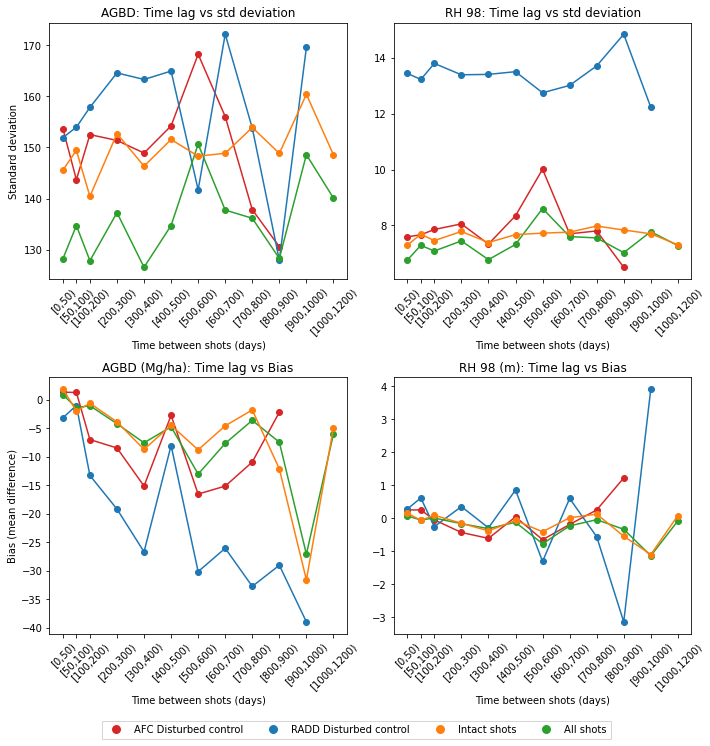

In [28]:
from matplotlib.lines import Line2D
n_lags = len(time_lags) - 1
lags_text = [f"[{time_lags[n_lags - i]},{time_lags[n_lags - (i+1)]})" for i in range(n_lags)]
x_lags = time_lags[1:]

lms = 10
legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='AFC Disturbed control',
            markerfacecolor='tab:red', markersize=lms),
        Line2D([0], [0], marker='o', color='w', label='RADD Disturbed control', 
            markerfacecolor='tab:blue', markersize=lms),
        Line2D([0], [0], marker='o', color='w', label='Intact shots', 
            markerfacecolor='tab:orange', markersize=lms),
        Line2D([0], [0], marker='o', color='w', label='All shots', 
            markerfacecolor='tab:green', markersize=lms),]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axi = ax[0,0]
axi.plot(x_lags, afc_stats[0], '-o', color="tab:red")
axi.plot(x_lags, radd_stats[0], '-o', color="tab:blue")
axi.plot(x_lags, all_stats[0], '-o', color="tab:green")
axi.plot(x_lags, intact_stats[0], '-o', color="tab:orange")
axi.set_xlabel("Time between shots (days)")
axi.set_ylabel("Standard deviation")
axi.set_title("AGBD: Time lag vs std deviation")
axi.set_xticks(x_lags[::-1], lags_text, rotation=45)


axi = ax[0,1]
axi.plot(x_lags, afc_stats[1], '-o', color="tab:red")
axi.plot(x_lags, radd_stats[1], '-o', color="tab:blue")
axi.plot(x_lags, all_stats[1], '-o', color="tab:green")
axi.plot(x_lags, intact_stats[1], '-o', color="tab:orange")
axi.set_xlabel("Time between shots (days)")
axi.set_title("RH 98: Time lag vs std deviation")
axi.set_xticks(x_lags[::-1], lags_text, rotation=45)

axi = ax[1,0]
axi.plot(x_lags, afc_stats[2], '-o', color="tab:red")
axi.plot(x_lags, radd_stats[2], '-o', color="tab:blue")
axi.plot(x_lags, all_stats[2], '-o', color="tab:green")
axi.plot(x_lags, intact_stats[2], '-o', color="tab:orange")
axi.set_xlabel("Time between shots (days)")
axi.set_ylabel("Bias (mean difference)")
axi.set_title("AGBD (Mg/ha): Time lag vs Bias")
axi.set_xticks(x_lags[::-1], lags_text, rotation=45)


axi = ax[1,1]
axi.plot(x_lags, afc_stats[3], '-o', color="tab:red")
axi.plot(x_lags, radd_stats[3], '-o', color="tab:blue")
axi.plot(x_lags, all_stats[3], '-o', color="tab:green")
axi.plot(x_lags, intact_stats[3], '-o', color="tab:orange")
axi.set_xlabel("Time between shots (days)")
axi.set_title("RH 98 (m): Time lag vs Bias")
axi.set_xticks(x_lags[::-1], lags_text, rotation=45)

fig.subplots_adjust(wspace=0.30, hspace=0.5)
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.0),fancybox=False, shadow=False, ncol=4)
plt.tight_layout()

In [ ]:
for d in [("AFC", afc_stats), ("RADD", radd_stats), ("All", all_stats), ("Intact", intact_stats)]:
    name, stats = d
    df = pd.DataFrame({
        "lags": x_lags,
        "agbd_sd": stats[0],
        "rh98_sd": stats[1],
        "agbd_bias": stats[2],
        "rh98_bias": stats[3],
    })
    print(name)
    print("------------------")
    print("AGBD SD Correlation: {:.2f}".format(df["lags"].corr(df["agbd_sd"])))
    print("RH98 SD Correlation: {:.2f}".format(df["lags"].corr(df["rh98_sd"])))
    print("AGBD Bias Correlation: {:.2f}".format(df["lags"].corr(df["agbd_bias"])))
    print("RH98 Bias Correlation: {:.2f}".format(df["lags"].corr(df["rh98_bias"])))
    print()
